# Text generation with Llama2
Examples of text generation with Llama2 and Hugging Face Transformers library:
1. Using the generate() method with different output and input sizes, and modifying the temperature.
2. Using the model callback.
3. Measuring perplexity of a sequence longer than the context length of the model.

In [1]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import accelerate
import bitsandbytes  # Works with CUDA
import numpy as np
from .autonotebook import tqdm as notebook_tqdm
import pandas as pd
import time

# device = torch.device("mps") if torch.backends.mps.is_built() else torch.device("cpu")  # To run on mac
device = "cuda:0" if torch.cuda.is_available() else "cpu"

/home/mce/miniconda3/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get model and tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"
access_token = os.environ["HF_API_KEY"]

# Quantization: https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/quantization
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", quantization_config=bnb_config,  token=access_token);  # In colab cache_dir can be set to a folder in GDrive
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=access_token);

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mce/anaconda3/envs/hf/lib/python3.9/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


## Configuration / Architecture

In [3]:
print("Number of parameters (all, excluding embeddings, trainable): ({}, {}, {})".format(model.num_parameters(), model.num_parameters(exclude_embeddings=True), model.num_parameters(only_trainable=True)))
print("Number of attention heads: ", model.config.num_attention_heads)
print("Number of hidden layers: ", model.config.num_hidden_layers)
print("Number of key_value heads (Grouped Query Attention): ", model.config.num_key_value_heads)
print("Hidden size: ", model.config.hidden_size)
print("Hidden activation: ", model.config.hidden_act)
print("Intermediate size: ", model.config.intermediate_size)
print("Maximum sequence length (context): ", model.config.max_position_embeddings)
print("Vocabulary size: ", model.config.vocab_size)
# print("\nModel:\n", model)

Number of parameters (all, excluding embeddings, trainable): (6738415616, 6607343616, 262410240)
Number of attention heads:  32
Number of hidden layers:  32
Number of key_value heads (Grouped Query Attention):  32
Hidden size:  4096
Hidden activation:  silu
Intermediate size:  11008
Maximum sequence length (context):  4096
Vocabulary size:  32000


## 1. Text generation with the generate() method
[Documentation](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/text_generation)

In [4]:
prompt = "What does the fox say?"
model_inputs = tokenizer(prompt, return_tensors="pt").to(device) # Use return_length to return input lenght in tokens
print("Tokenized input size: ", model_inputs.input_ids.shape)

Tokenized input size:  torch.Size([1, 8])


### 1.1 Generating different lenghts of outputs
Computation time depends on the size of the output that can be specified or defaults to maximum of 20 tokens (unless EOS is generated before).  

The output has the following objects:
* sequences: token ids from the generated text, its lenght is the sum of the new tokens plus the prompt tokens.
* scores: probabilities associated to each predicted token, it is a tensor of size (number of new tokens, vocabulary size).

In [5]:
output = model.generate(**model_inputs, max_new_tokens=16, output_scores=True, return_dict_in_generate=True);  #True to return prediction scores, format return_dict_in_generate
text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)

print(text)
print("------------------------------------------------------")
print("Output shape (tokens): ", output.sequences.shape)
print("Number of scores and each score tensor shape: ({}, {})".format(len(output.scores), output.scores[0].shape))

What does the fox say? (Sung to the tune of "The Wheels on the Bus")
------------------------------------------------------
Output shape (tokens):  torch.Size([1, 24])
Number of scores and each score tensor shape: (16, torch.Size([1, 32000]))


In [6]:
output_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
prediction_time = []
decoding_time = []

for output_size in output_sizes:
  to = time.time()
  output = model.generate(**model_inputs, max_new_tokens=output_size, output_scores=True, return_dict_in_generate=True);  #True to return prediction scores, format return_dict_in_generate
  prediction_time.append(time.time() - to)

  text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
  decoding_time.append(time.time() - to)

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


In [7]:
# Results
df = pd.DataFrame({"Output sizes (tokens)": output_sizes, "Prediction time (s)": prediction_time, "Prediction + decoding time (s)": decoding_time})
display(df)

,Output sizes (tokens),Prediction time (s),Prediction + decoding time (s)
0,16,1.293991,1.294172
1,32,2.320033,2.320272
2,64,4.393761,4.394002
3,128,8.621534,8.621843
4,256,2.589081,2.589355
5,512,4.850044,4.850321
6,1024,16.727992,16.728397
7,2048,140.912367,140.914176
8,4096,282.365057,282.368596


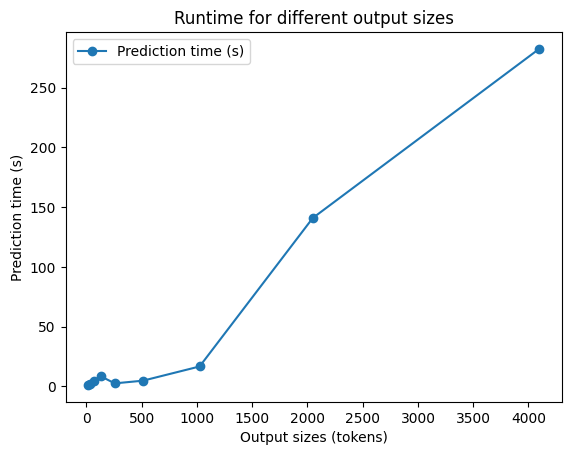

In [8]:
# Impact output size / requested tokens
plot = df.plot(title="Runtime for different output sizes", x="Output sizes (tokens)", y="Prediction time (s)", ylabel="Prediction time (s)", style="-o")

### 1.2 Generating an output of 16 tokens with different lenghts of inputs

In [9]:
prompt = "Michelangelo di Lodovico Buonarroti Simoni (6 March 1475 – 18 February 1564), known as Michelangelo, was an Italian sculptor, painter, architect, and poet of the High Renaissance. Born in the Republic of Florence, his work was inspired by models from classical antiquity and had a lasting influence on Western art. Michelangelo's creative abilities and mastery in a range of artistic arenas define him as an archetypal Renaissance man, along with his rival and elder contemporary, Leonardo da Vinci. Given the sheer volume of surviving correspondence, sketches, and reminiscences, Michelangelo is one of the best-documented artists of the 16th century. He was lauded by contemporary biographers as the most accomplished artist of his era. Michelangelo achieved fame early; two of his best-known works, the Pietà and David, were sculpted before the age of thirty. Although he did not consider himself a painter, Michelangelo created two of the most influential frescoes in the history of Western art: the scenes from Genesis on the ceiling of the Sistine Chapel in Rome, and The Last Judgment on its altar wall. His design of the Laurentian Library pioneered Mannerist architecture. At the age of 71, he succeeded Antonio da Sangallo the Younger as the architect of St. Peter's Basilica. Michelangelo transformed the plan so that the western end was finished to his design, as was the dome, with some modification, after his death. Michelangelo was the first Western artist whose biography was published while he was alive. In fact, three biographies were published during his lifetime. One of them, by Giorgio Vasari, proposed that Michelangelo's work transcended that of any artist living or dead, and was supreme in not one art alone but in all three. In his lifetime, Michelangelo was often called Il Divino (the divine one). His contemporaries often admired his terribilità—his ability to instill a sense of awe in viewers of his art. Attempts by subsequent artists to imitate the expressive physicality of Michelangelo's style contributed to the rise of Mannerism, a short-lived movement in Western art between the High Renaissance and the Baroque."
model_inputs = tokenizer(prompt, return_tensors="pt").to(device)  #Use return_length to return input lenght in tokens
print("Tokenized input size: ", model_inputs.input_ids.shape)

Tokenized input size:  torch.Size([1, 524])


In [10]:
input_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
prediction_time = []
decoding_time = []

for input_size in input_sizes:
  inputs = model_inputs.input_ids[:input_size]
  to = time.time()
  output = model.generate(inputs, max_new_tokens=16, output_scores=True, return_dict_in_generate=True)  #True to return prediction scores, format return_dict_in_generate
  prediction_time.append(time.time() - to)

  text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
  decoding_time.append(time.time() - to)


In [11]:
# Results
df = pd.DataFrame({"Input size (tokens)": input_sizes, "Prediction time (s)": prediction_time, "Prediction + decoding time (s)": decoding_time})
display(df)

,Input size (tokens),Prediction time (s),Prediction + decoding time (s)
0,16,1.972342,1.975091
1,32,1.931416,1.932227
2,64,1.933663,1.934433
3,128,1.929686,1.930371
4,256,1.931432,1.932089
5,512,1.935114,1.935821
6,1024,1.931911,1.932614
7,2048,0.935798,0.936360
8,4096,1.933145,1.933806


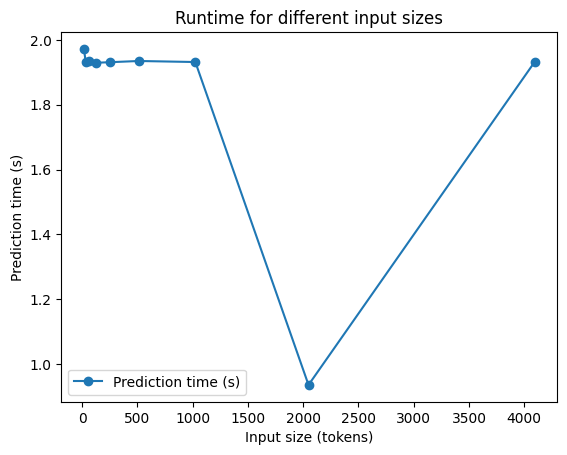

In [12]:
# Impact input size / prompt length
plot = df.plot(title="Runtime for different input sizes", x="Input size (tokens)", y="Prediction time (s)", ylabel="Prediction time (s)", style="-o")

### 1.3. Text generation modifying the temperature
[Documentation](https://huggingface.co/docs/transformers/internal/generation_utils): A value smaller than 1 decreases randomness (and vice versa), with 0 being equivalent to shifting all probability mass to the most likely token.

In [13]:
prompt = "What does the fox say?"
model_inputs = tokenizer(prompt, return_tensors="pt").to(device)  #Use return_length to return input lenght in tokens
print("Tokenized input size: ", model_inputs.input_ids.shape)

print("---------------------t=0.1------------------------------")
for i in range(10):
  output = model.generate(**model_inputs, max_new_tokens=8, temperature=0.1, output_scores=True, return_dict_in_generate=True)  #True to return prediction scores, format return_dict_in_generate
  print(tokenizer.decode(output.sequences[0], skip_special_tokens=True))

print("---------------------t=0.5------------------------------")
for i in range(10):
  output = model.generate(**model_inputs, max_new_tokens=8, temperature=0.5, output_scores=True, return_dict_in_generate=True)  #True to return prediction scores, format return_dict_in_generate
  print(tokenizer.decode(output.sequences[0], skip_special_tokens=True))

print("---------------------t=1------------------------------")
for i in range(10):
  output = model.generate(**model_inputs, max_new_tokens=8, temperature=1, output_scores=True, return_dict_in_generate=True)  #True to return prediction scores, format return_dict_in_generate
  print(tokenizer.decode(output.sequences[0], skip_special_tokens=True))

Tokenized input size:  torch.Size([1, 8])
---------------------t=0.1------------------------------
What does the fox say? (Fox say "Ring-
What does the fox say? (Fox say "Ring-
What does the fox say? (Fox say "Ring-
What does the fox say? (You know the song)
 everybody
What does the fox say? (Fox say "Ring-
What does the fox say? (You know the song)
 everybody
What does the fox say? (You know the song)
 everybody
What does the fox say? (You know the song)
 everybody
What does the fox say? (You know the song)
 everybody
What does the fox say? (You know the song)
 nobody
---------------------t=0.5------------------------------
What does the fox say? (You know the song)
 Begriffe
What does the fox say? (A parody of the song "
What does the fox say? (Well, actually, I think I
What does the fox say?
ϊ ♪ �
What does the fox say? (Sung to the tune of
What does the fox say? (Answer: It says "Ring
What does the fox say? (What does the fox say?)
What does the fox say? (A parody of the song "
Wha

## 2. Text generation using model call
[Documentation](https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/output#transformers.modeling_outputs.CausalLMOutput): The model output returns the logits, which are the prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).

In [14]:
prompt = "What does the fox say?"
model_inputs = tokenizer(prompt, return_tensors="pt").to(device)  #Use return_length to return input lenght in tokens
print("Tokenized input size: ", model_inputs.input_ids.shape)

Tokenized input size:  torch.Size([1, 8])


In [15]:
%%time
predictions = model(model_inputs.input_ids)  #Returns: loss, logits, hidden_states, attentions
output_logits = predictions.logits  # Raw, unnormalized scores

probs = torch.nn.functional.softmax(output_logits, dim=-1)
# preds = np.argmax(probs.detach().cpu().numpy(), axis=-1)  # Get label from logits
preds = torch.argmax(probs[0], dim=-1)

print(tokenizer.decode(preds, skip_special_tokens=True))
print("------------------------------------------------------")
print("Output shape (tokens): ", preds.shape)
print("Output shape (logits): ", output_logits.shape)
print("------------------------------------------------------")

# Temperature: https://stackoverflow.com/questions/59346448/if-temperature-is-not-defined-in-softmax-does-it-mean-temperature-is-1
temperature = 0.1
probs = torch.nn.functional.softmax(output_logits / temperature, dim=-1)
preds = torch.argmax(probs[0], dim=-1)
print("Adding temperature: ")
print(tokenizer.decode(preds, skip_special_tokens=True))
print("------------------------------------------------------")

nobody is the Biblex say? (
------------------------------------------------------
Output shape (tokens):  torch.Size([8])
Output shape (logits):  torch.Size([1, 8, 32000])
------------------------------------------------------
Adding temperature: 
nobody is the Biblex say? (
------------------------------------------------------
CPU times: user 267 ms, sys: 48 ms, total: 315 ms
Wall time: 318 ms


## 3. Measure perplexity of a sequence longer than the context window
[Documentation](https://huggingface.co/docs/transformers/perplexity)

In [16]:
prompt = "What does the fox say? " * 1000
model_inputs = tokenizer(prompt, return_tensors="pt").to(device)  #Use return_length to return input lenght in tokens
print("Tokenized input size: ", model_inputs.input_ids.shape)

Tokenized input size:  torch.Size([1, 7002])


In [17]:
max_length = model.config.max_position_embeddings
stride = 512
seq_len = model_inputs.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in range(0, seq_len, stride):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = model_inputs.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc

    if begin_loc == 512:
      break

    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())
print("Perplexity: ", ppl.item())

Perplexity:  1.0058621168136597
